In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np

import tike.ptycho
import tike.view

In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.7.1.dev18+gc715956.d20191104
numpy is version 1.17.3


# Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

Normalize input uint8 images to the `[0, 1]` and `[0, pi]` ranges.

In [3]:
amplitude = plt.imread("../tests/data/Cryptomeria_japonica-0128.tif") / 255
phase = plt.imread("../tests/data/Bombus_terrestris-0128.tif") / 255 * np.pi
np.min(phase), np.max(phase)

(0.036959913571644624, 3.129272682399245)

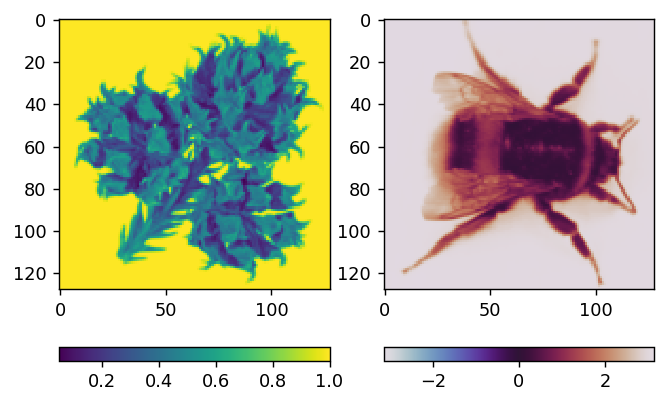

(1, 128, 128)

(-0.9999241101148306+0.012319659535238529j) (0.9951469164070644+0.0984002782796427j)


In [4]:
original = np.expand_dims(amplitude * np.exp(1j * phase), axis=0)
tike.view.plot_phase(original[0])
original.shape

### Define the probe

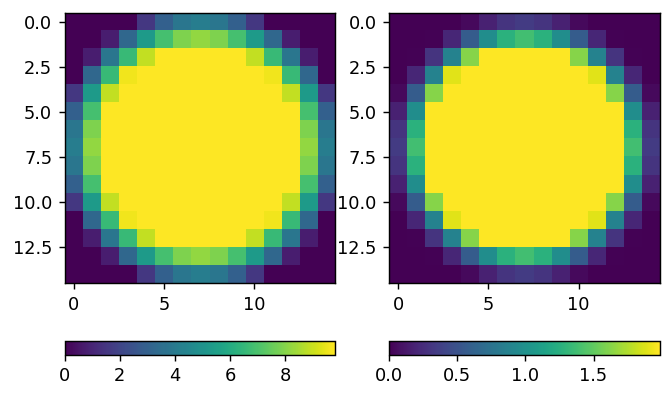

In [5]:
pw = 15 # probe width
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2) * 10
probe = np.expand_dims(probe, axis=0)
tike.view.plot_complex(probe[0])

### Define the trajectory

In [6]:
v, h = np.meshgrid(
    np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=True),
    np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=True),
    indexing='ij'
    )

In [7]:
scan = np.expand_dims(np.stack((np.ravel(v), np.ravel(h)), axis=1), axis=0)
scan.shape

(1, 576, 2)

## Simulate data acquisition

In [8]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(detector_shape=pw*3,
                            probe=probe, scan=scan,
                            psi=original)
np.random.seed(0)
data = np.random.poisson(data)
data.shape

(1, 576, 45, 45)

/home/beams/DCHING/miniconda3/envs/tike/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


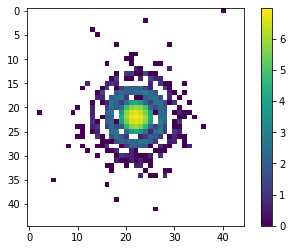

(0, 1119)

In [9]:
plt.imshow(np.fft.fftshift(np.log(data[0, 11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

Now we need to try and reconstruct psi.

In [10]:
# Start with a guess of all zeros for psi
new_psi = np.ones(original.shape, dtype=complex)

INFO:tike.ptycho.ptycho:cgrad on 1 - 576 by 45 grids for 45 iterations


# congujate gradient parameters
iteration, step size object, step size probe, function min
   0, 2.500e-01, 0.000e+00, -1.3346411e+07


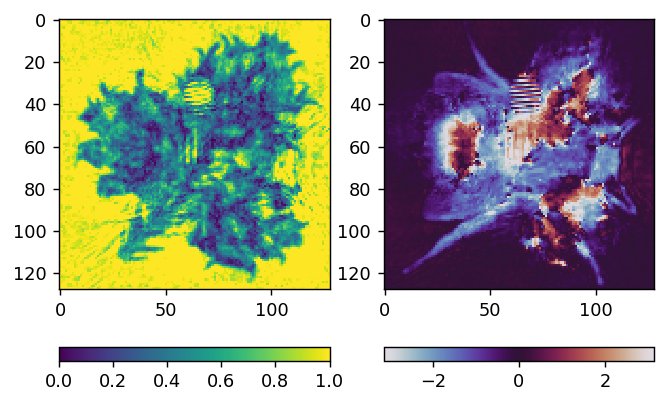

INFO:tike.ptycho.ptycho:cgrad on 1 - 576 by 45 grids for 45 iterations


(-1.1112474-0.3754109j) (1.4699695-0.16849582j)
# congujate gradient parameters
iteration, step size object, step size probe, function min
   0, 2.500e-01, 0.000e+00, -1.5738106e+07


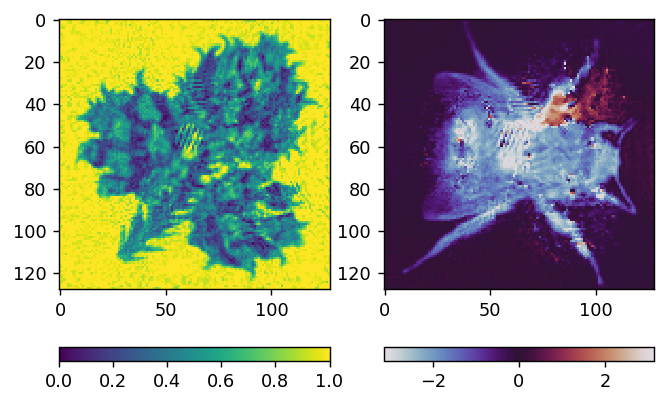

INFO:tike.ptycho.ptycho:cgrad on 1 - 576 by 45 grids for 45 iterations


(-1.0622245-0.5684069j) (1.3833799+0.04872201j)
# congujate gradient parameters
iteration, step size object, step size probe, function min
   0, 2.500e-01, 0.000e+00, -1.5976698e+07


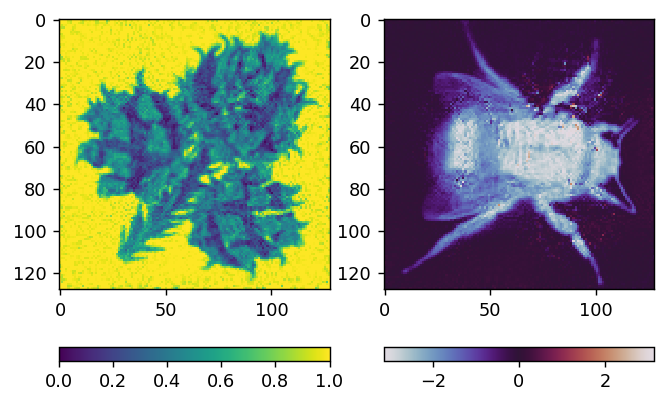

INFO:tike.ptycho.ptycho:cgrad on 1 - 576 by 45 grids for 45 iterations


(-1.0754732-0.3243711j) (1.4227769-0.2760122j)
# congujate gradient parameters
iteration, step size object, step size probe, function min
   0, 2.500e-01, 0.000e+00, -1.6034658e+07


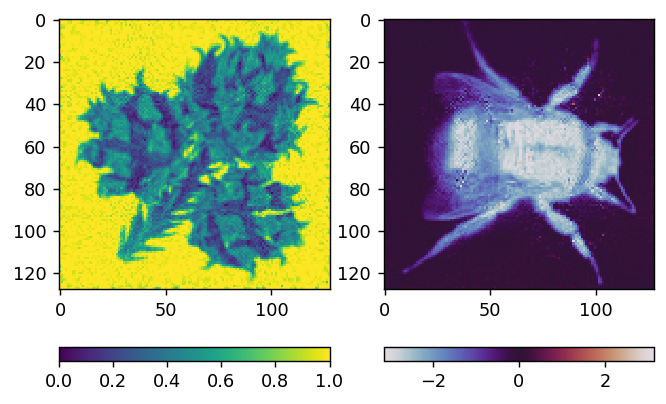

INFO:tike.ptycho.ptycho:cgrad on 1 - 576 by 45 grids for 45 iterations


(-1.0321548-0.32466668j) (1.4655526-0.2949398j)
# congujate gradient parameters
iteration, step size object, step size probe, function min
   0, 2.500e-01, 0.000e+00, -1.6043626e+07


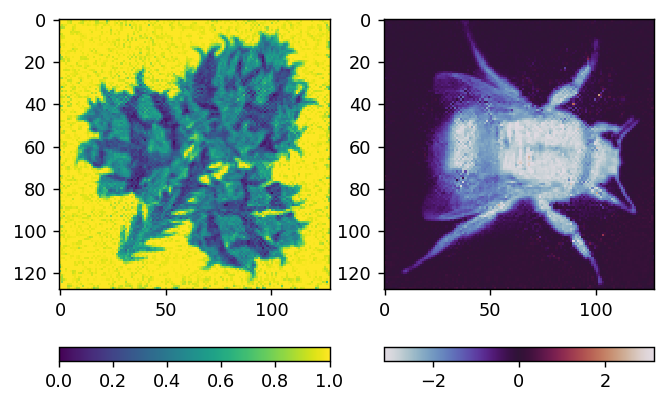

(-1.0440661-0.25805756j) (1.5200832-0.2932003j)


In [11]:
for i in range(5):
    new_psi = tike.ptycho.reconstruct(data=data,
                                      probe=probe, scan=scan,
                                      psi=new_psi,
                                      algorithm='cgrad',
                                      num_iter=8, gamma_psi=1)
    tike.view.plot_phase(new_psi[0], amin=0, amax=1)